In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [2]:
BATCH_SIZE = 48

image_height = 299
image_width = 299

In [3]:
data_generator_1 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=5,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            brightness_range = [0.95,1.05],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'                                   
                        )

print('Data Augmentation 1 was created')

data_generator_2 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            brightness_range = [0.9,1.1],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'                                   
                        )
print('Data Augmentation 2 was created')

data_generator_3 = ImageDataGenerator (rescale=1./255)

Data Augmentation 1 was created
Data Augmentation 2 was created


In [4]:
train_generator1 = data_generator_1.flow_from_directory(
    directory = r"C:\Users\Rupam\model\chest_xray\chest_xray\train", # images data path / folder in which images are there
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

print('Data Augmentation 1 was used to generate train data set\n')

# train_generator2 = data_generator_2.flow_from_directory(
#     directory = "/kaggle/input/chest-xray-pneumonia/chest_xray/train", # images data path / folder in which images are there
#     color_mode = "rgb",
#     target_size = (image_height, image_width), # image height , image width
#     class_mode = "categorical",
#     batch_size = BATCH_SIZE,
#     shuffle = True,
#     seed = 42)

# print('Data Augmentation 2 was used to generate train data set\n')

# train_generator3 = data_generator_3.flow_from_directory(
#     directory = "/kaggle/input/chest-xray-pneumonia/chest_xray/train", # images data path / folder in which images are there
#     color_mode = "rgb",
#     target_size = (image_height, image_width), # image height , image width
#     class_mode = "categorical",
#     batch_size = BATCH_SIZE,
#     shuffle = True,
#     seed = 42)

# print('Original images was used to generate train data set\n')

test_generator = data_generator_3.flow_from_directory(
    directory = r"C:\Users\Rupam\model\chest_xray\chest_xray\test", # images data path / folder in which images are there
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)


# val_generator = data_generator_3.flow_from_directory(
#     directory = "/kaggle/input/chest-xray-pneumonia/chest_xray/val", # images data path / folder in which images are there
#     color_mode = "rgb",
#     target_size = (image_height, image_width), # image height , image width
#     class_mode = "categorical",
#     batch_size = BATCH_SIZE,
#     shuffle = True,
#     seed = 42)

Found 5216 images belonging to 2 classes.
Data Augmentation 1 was used to generate train data set

Found 625 images belonging to 2 classes.


In [5]:
dict_class = train_generator1.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'NORMAL': 0, 'PNEUMONIA': 1}
Class labels: ['NORMAL', 'PNEUMONIA']


In [6]:
import numpy as np

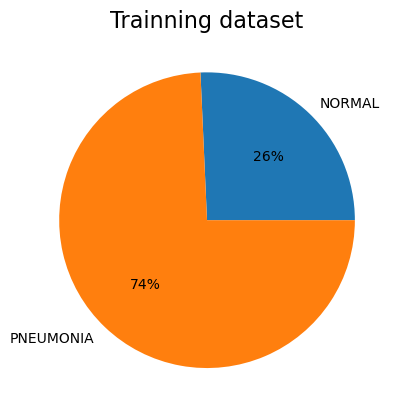

In [7]:
frequency = np.unique(train_generator1.classes, return_counts=True)

plt.title("Trainning dataset", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

In [8]:
print("Dataset Characteristics of Train Data Set:")
print("Number of images:", len(train_generator1.classes))
print("Number of normal images:", len([label for label in train_generator1.classes if label == 0]))
print("Number of pneumonia images:", len([label for label in train_generator1.classes if label == 1]))
print()

print("Dataset Characteristics of Test Data Set:")
print("Number of images:", len(test_generator.classes))
print("Number of normal images:", len([label for label in test_generator.classes if label == 0]))
print("Number of pneumonia images:", len([label for label in test_generator.classes if label == 1]))
print()

Dataset Characteristics of Train Data Set:
Number of images: 5216
Number of normal images: 1341
Number of pneumonia images: 3875

Dataset Characteristics of Test Data Set:
Number of images: 625
Number of normal images: 234
Number of pneumonia images: 391



In [9]:
from sklearn.utils.class_weight import compute_class_weight

In [10]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator1.classes), y= train_generator1.classes)
class_weights = dict(zip(np.unique(train_generator1.classes), class_weights))
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

Train image data from Data Augmentation 1


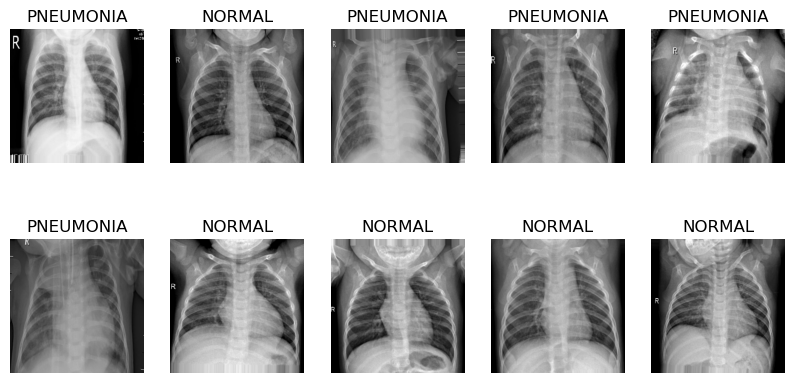

In [11]:
print('Train image data from Data Augmentation 1')
img, label = next(train_generator1)
# print(len(label))

plt.figure(figsize=[10, 5])
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])    
plt.show()

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
EPOCHS = 2

# Define the number of GPUs to use
num_gpus = 2

# Merge augmented image data for training
# merged_train_generator = chain(train_generator1, train_generator2, train_generator3)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.001, patience=10, verbose=1)

# For development purpose, we first limit the train data set to the original image data set
# train_data = merged_train_generator
# train_data = train_generator1
train_data = train_generator1
# train_data = test_generator

In [14]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121

# To chain two different data augmented images for training
from itertools import chain

#  Distributed Computing
import tensorflow as tf

In [15]:
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
#from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping 
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

In [17]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
 import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  0
TensorFlow version: 2.18.0


In [20]:
batch_x, batch_y = next(train_data)
print("Input batch shape:", batch_x.shape)  # Should be (batch_size, 224, 224, 3)

Input batch shape: (48, 299, 299, 3)


In [21]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

# Check for available GPUs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Define image size to match VGG16's expected input size
image_size = (224, 224)  # Must be (224, 224) for VGG16

# Define batch size and number of epochs
BATCH_SIZE = 32
EPOCHS = 10

# Create ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset and ensure images are resized to (224, 224)
train_data = train_datagen.flow_from_directory(
    r"C:\Users\Rupam\model\chest_xray\chest_xray\train",
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    r"C:\Users\Rupam\model\chest_xray\chest_xray\test",
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Check input shape
batch_x, batch_y = next(train_data)
print("Input batch shape:", batch_x.shape)  # Should be (batch_size, 224, 224, 3)

# Define distributed training strategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():
    # Load VGG16 without top layers
    base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model layers
    for layer in base_model_VGG16.layers:
        layer.trainable = False

    # Create a new model and add layers
    model_VGG16 = Sequential([
        base_model_VGG16,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])

    # Model summary
    print("Model Summary (VGG16):")
    model_VGG16.summary()

    # Compile the model
    model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_VGG16 = model_VGG16.fit(
    train_data, 
    epochs=EPOCHS, 
    validation_data=test_data
)

# Evaluate the model
val_loss_VGG16, val_accuracy_VGG16 = model_VGG16.evaluate(test_data)
print(f'Validation Loss: {val_loss_VGG16:.4f}')
print(f'Validation Accuracy: {val_accuracy_VGG16:.4f}')


Num GPUs Available:  0
Found 5216 images belonging to 2 classes.
Found 625 images belonging to 2 classes.
Input batch shape: (32, 224, 224, 3)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model Summary (VGG16):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,788,738 (56.41 MB)

 Trainable params: 74,050 (289.26 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

C:\Users\Rupam\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2564s 16s/step - accuracy: 0.7504 - loss: 0.7023 - val_accuracy: 0.8272 - val_loss: 0.4665
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1280s 8s/step - accuracy: 0.8917 - loss: 0.3331 - val_accuracy: 0.8672 - val_loss: 0.3907
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1262s 8s/step - accuracy: 0.9197 - loss: 0.2740 - val_accuracy: 0.8832 - val_loss: 0.3515
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1244s 8s/step - accuracy: 0.9137 - loss: 0.2766 - val_accuracy: 0.8960 - val_loss: 0.3289
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1248s 8s/step - accuracy: 0.9254 - loss: 0.2529 - val_accuracy: 0.8944 - val_loss: 0.3537
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1249s 8s/step - accuracy: 0.9296 - loss: 0.2374 - val_accuracy: 0.8960 - val_loss: 0.3295
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1238s 8s/step - accuracy: 0.9223 - loss: 0.2389 - val_accuracy: 0.9056 - val_loss: 0.3340
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1237s 8s/step - accuracy: 0.9398 - loss: 0.2099 

In [44]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

# Check for available GPUs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Define image size to match MobileNetV2's expected input size
image_size = (224, 224)  # MobileNetV2 requires (224, 224)

# Define batch size and number of epochs
BATCH_SIZE = 32
EPOCHS = 10

# Create ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset and ensure images are resized to (224, 224)
train_data = train_datagen.flow_from_directory(
     r"C:\Users\Rupam\model\chest_xray\chest_xray\train",
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
     r"C:\Users\Rupam\model\chest_xray\chest_xray\test",
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Check input shape
batch_x, batch_y = next(train_data)
print("Input batch shape:", batch_x.shape)  # Should be (batch_size, 224, 224, 3)

# Define distributed training strategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():
    # Load MobileNetV2 without top layers
    base_model_MobileNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model layers
    for layer in base_model_MobileNetV2.layers:
        layer.trainable = False

    # Create a new model and add layers
    model_MobileNetV2 = Sequential([
        base_model_MobileNetV2,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])

    # Model summary
    print("Model Summary (MobileNetV2):")
    model_MobileNetV2.summary()

    # Compile the model
    model_MobileNetV2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_MobileNetV2 = model_MobileNetV2.fit(
    train_data, 
    epochs=EPOCHS, 
    validation_data=test_data
)

# Evaluate the model
val_loss_MobileNetV2, val_accuracy_MobileNetV2 = model_MobileNetV2.evaluate(test_data)
print(f'Validation Loss: {val_loss_MobileNetV2:.4f}')
print(f'Validation Accuracy: {val_accuracy_MobileNetV2:.4f}')


Num GPUs Available:  0
Found 5216 images belonging to 2 classes.
Found 625 images belonging to 2 classes.
Input batch shape: (32, 224, 224, 3)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 10s 1us/step
Model Summary (MobileNetV2):


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,338 (9.27 MB)

 Trainable params: 172,354 (673.26 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.8293 - loss: 0.6457 - val_accuracy: 0.8960 - val_loss: 0.4318
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.9451 - loss: 0.3005 - val_accuracy: 0.8672 - val_loss: 0.5059
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.9435 - loss: 0.2703 - val_accuracy: 0.8800 - val_loss: 0.4045
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.9466 - loss: 0.2349 - val_accuracy: 0.8672 - val_loss: 0.4260
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.9525 - loss: 0.2210 - val_accuracy: 0.9008 - val_loss: 0.3195
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.9463 - loss: 0.2064 - val_accuracy: 0.9040 - val_loss: 0.3169
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.9502 - loss: 0.1924 - val_accuracy: 0.8800 - val_loss: 0.3528
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.9537 - loss: 0.1784 - val_accu

In [46]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

# Check for available GPUs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Define image size to match DenseNet121's expected input size
image_size = (224, 224)  # DenseNet121 requires (224, 224)

# Define batch size and number of epochs
BATCH_SIZE = 32
EPOCHS = 10

# Create ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset and ensure images are resized to (224, 224)
train_data = train_datagen.flow_from_directory(
    r"C:\Users\Rupam\model\chest_xray\chest_xray\train",
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    r"C:\Users\Rupam\model\chest_xray\chest_xray\test",
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Check input shape
batch_x, batch_y = next(train_data)
print("Input batch shape:", batch_x.shape)  # Should be (batch_size, 224, 224, 3)

# Define distributed training strategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():
    # Load DenseNet121 without top layers
    base_model_DenseNet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model layers
    for layer in base_model_DenseNet.layers:
        layer.trainable = False

    # Create a new model and add layers
    model_DenseNet = Sequential([
        base_model_DenseNet,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])

    # Model summary
    print("Model Summary (DenseNet121):")
    model_DenseNet.summary()

    # Compile the model
    model_DenseNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_DenseNet = model_DenseNet.fit(
    train_data, 
    epochs=EPOCHS, 
    validation_data=test_data
)

# Evaluate the model
val_loss_DenseNet, val_accuracy_DenseNet = model_DenseNet.evaluate(test_data)
print(f'Validation Loss: {val_loss_DenseNet:.4f}')
print(f'Validation Accuracy: {val_accuracy_DenseNet:.4f}')


Num GPUs Available:  0
Found 5216 images belonging to 2 classes.
Found 625 images belonging to 2 classes.
Input batch shape: (32, 224, 224, 3)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 34s 1us/step
Model Summary (DenseNet121):


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,177,090 (27.38 MB)

 Trainable params: 139,586 (545.26 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 533s 3s/step - accuracy: 0.8234 - loss: 0.6117 - val_accuracy: 0.8064 - val_loss: 0.5918
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 493s 3s/step - accuracy: 0.9201 - loss: 0.3372 - val_accuracy: 0.8208 - val_loss: 0.5198
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - accuracy: 0.9241 - loss: 0.2888 - val_accuracy: 0.8736 - val_loss: 0.4224
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 498s 3s/step - accuracy: 0.9444 - loss: 0.2421 - val_accuracy: 0.8208 - val_loss: 0.5265
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.9482 - loss: 0.2264 - val_accuracy: 0.8560 - val_loss: 0.4736
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 506s 3s/step - accuracy: 0.9512 - loss: 0.2006 - val_accuracy: 0.8832 - val_loss: 0.3538
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 500s 3s/step - accuracy: 0.9431 - loss: 0.2198 - val_accuracy: 0.8704 - val_loss: 0.3908
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 506s 3s/step - accuracy: 0.9476 - loss: 0.1910 - val_accu

In [48]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

# Check for available GPUs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Define image size to match InceptionV3's expected input size
image_size = (299, 299)  # InceptionV3 requires (299, 299)

# Define batch size and number of epochs
BATCH_SIZE = 32
EPOCHS = 10

# Create ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset and ensure images are resized to (299, 299)
train_data = train_datagen.flow_from_directory(
    r"C:\Users\Rupam\model\chest_xray\chest_xray\train",
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    r"C:\Users\Rupam\model\chest_xray\chest_xray\test",
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Check input shape
batch_x, batch_y = next(train_data)
print("Input batch shape:", batch_x.shape)  # Should be (batch_size, 299, 299, 3)

# Define distributed training strategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():
    # Load InceptionV3 without top layers
    base_model_Inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    # Freeze the base model layers
    for layer in base_model_Inception.layers:
        layer.trainable = False

    # Create a new model and add layers
    model_Inception = Sequential([
        base_model_Inception,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])

    # Model summary
    print("Model Summary (InceptionV3):")
    model_Inception.summary()

    # Compile the model
    model_Inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_Inception = model_Inception.fit(
    train_data, 
    epochs=EPOCHS, 
    validation_data=test_data
)

# Evaluate the model
val_loss_Inception, val_accuracy_Inception = model_Inception.evaluate(test_data)
print(f'Validation Loss: {val_loss_Inception:.4f}')
print(f'Validation Accuracy: {val_accuracy_Inception:.4f}')

Num GPUs Available:  0
Found 5216 images belonging to 2 classes.
Found 625 images belonging to 2 classes.
Input batch shape: (32, 299, 299, 3)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 101s 1us/step
Model Summary (InceptionV3):


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,073,442 (84.20 MB)

 Trainable params: 270,658 (1.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 759s 5s/step - accuracy: 0.8547 - loss: 0.5830 - val_accuracy: 0.8528 - val_loss: 0.5275
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 738s 5s/step - accuracy: 0.9361 - loss: 0.3134 - val_accuracy: 0.8656 - val_loss: 0.4743
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 737s 5s/step - accuracy: 0.9354 - loss: 0.2678 - val_accuracy: 0.8768 - val_loss: 0.4160
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 727s 4s/step - accuracy: 0.9359 - loss: 0.2447 - val_accuracy: 0.8256 - val_loss: 0.5387
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 723s 4s/step - accuracy: 0.9498 - loss: 0.2033 - val_accuracy: 0.8640 - val_loss: 0.4024
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 730s 4s/step - accuracy: 0.9463 - loss: 0.2127 - val_accuracy: 0.8736 - val_loss: 0.3959
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 742s 5s/step - accuracy: 0.9543 - loss: 0.1875 - val_accuracy: 0.8592 - val_loss: 0.4245
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 735s 5s/step - accuracy: 0.9394 - loss: 0.1958 - val_accu

In [52]:
data = {
    'VGG16': val_accuracy_VGG16, 
    'MobileNet': val_accuracy_MobileNetV2,
    'DenseNet': val_accuracy_DenseNet,
    'Inception': val_accuracy_Inception
}

In [56]:
import pandas as pd

In [58]:
df = pd.DataFrame.from_dict(data, orient='index', columns=['accuracy'])
df = df.reset_index().rename(columns={'index': 'model'})

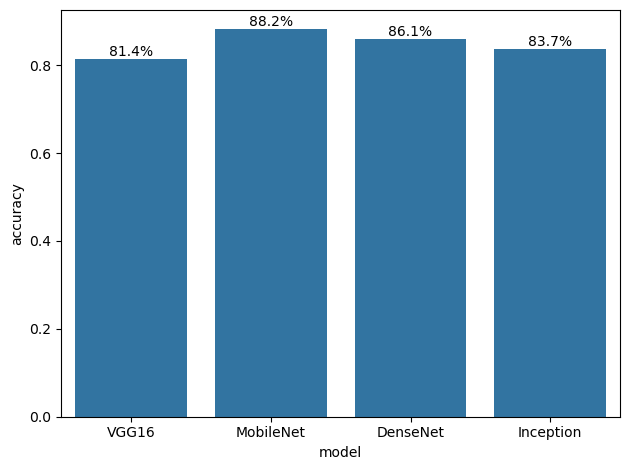

In [60]:
sns.barplot(x='model', y='accuracy', data=df)

# Add labels to bars
ax = plt.gca()
for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f"{x:.1%}" for x in bar.datavalues], fontsize=10)

# Adjust the layout
plt.tight_layout()

plt.show()

In [62]:
# Fine-tune the model with frozen layers

# Unfreeze the base_model
no_base_layers = len(model_Inception.layers)
print('No. of base layers in the model = {}\n'.format(no_base_layers))

# no of layers for fine-tune
no_finetune_layers = int(no_base_layers/2)
print('No. of layers for fine-tune = {}'.format(no_finetune_layers))

No. of base layers in the model = 7

No. of layers for fine-tune = 3


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step


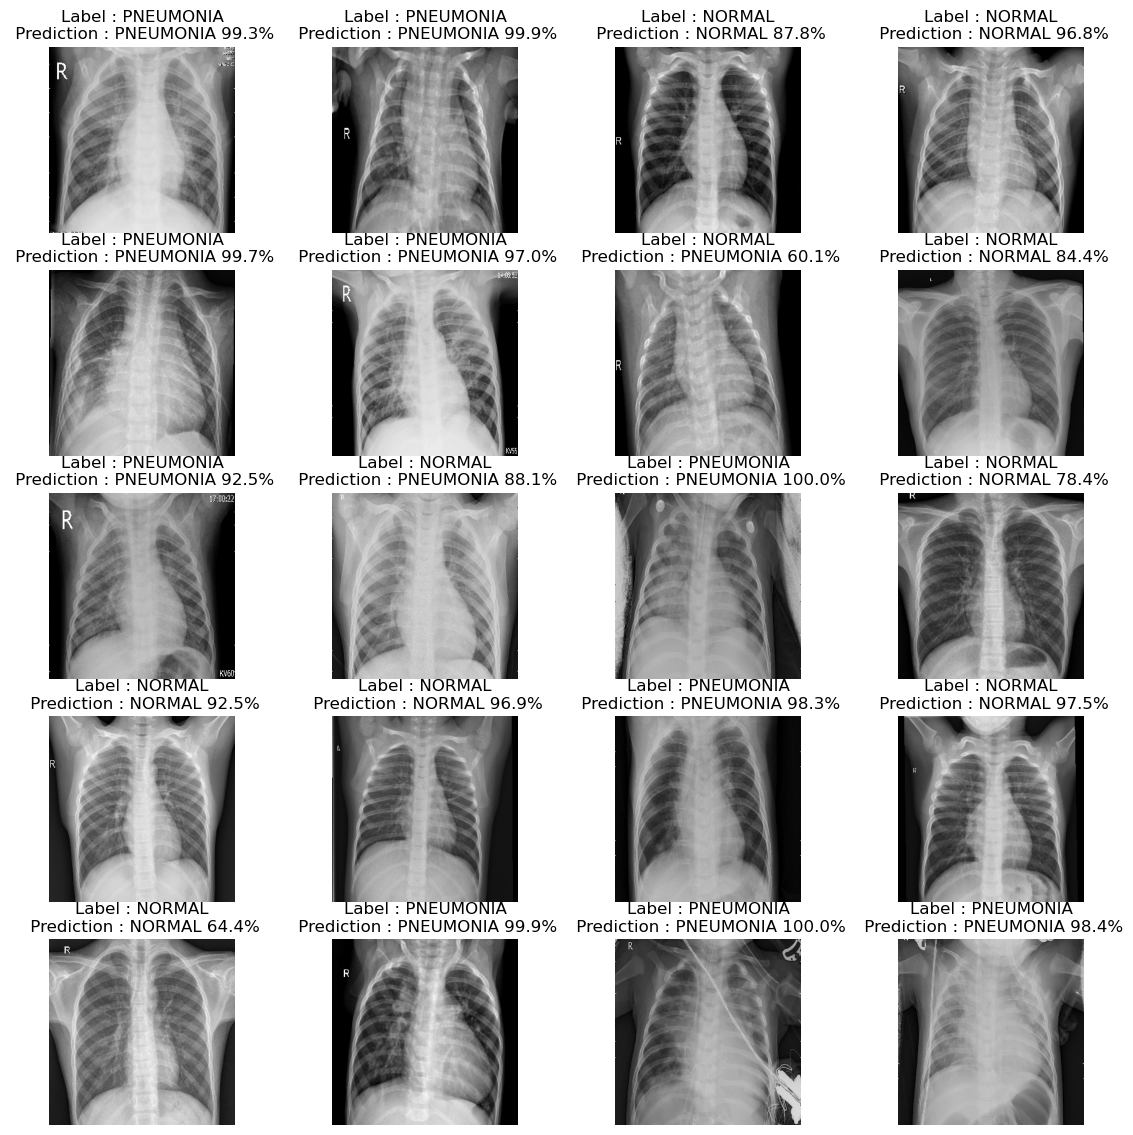

In [74]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_Inception.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

Lung opacity (whiteness in the lungs)
Texture differences between healthy and infected lungs

Throughput

In [77]:
import time

In [79]:
test_generator.reset()
img, label = next(test_generator)

start_time = time.time()  # Start timing
prediction = model_Inception.predict(img)
end_time = time.time()  # End timing

test_pred_classes = np.argmax(prediction, axis=1)

# Calculate time taken
inference_time = end_time - start_time

# Count pneumonia-positive cases
pneumonia_class_index = dict_class["PNEUMONIA"]  # Get class index for pneumonia
pneumonia_count = np.sum(test_pred_classes == pneumonia_class_index)

# Calculate throughput
throughput = pneumonia_count / inference_time
print(f"Throughput: {throughput:.2f} pneumonia-positive cases per second")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 459ms/step
Throughput: 25.18 pneumonia-positive cases per second
